<a href="https://colab.research.google.com/github/Greta-gerasimov/PyT/blob/L7_sequences_PyT/HW_07_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
!pip install stop-words pymorphy2

In [122]:
!pip install torchmetrics

In [123]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("punkt")

from string import punctuation
from stop_words import get_stop_words
# from pymorphy2 import MorphAnalyzer

import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [124]:
max_words = 1000
max_len = 10
num_classes = 1

epochs = 15
batch_size = 512
print_batch_n = 100

In [125]:
train_df = pd.read_csv('/content/twitter_train.csv')


In [126]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [127]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [128]:
X_train, X_valid = train_test_split(train_df, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape

((23971, 3), (7991, 3))

In [129]:
X_train.label.value_counts()

0    22288
1     1683
Name: label, dtype: int64

In [130]:
X_valid.label.value_counts()

0    7432
1     559
Name: label, dtype: int64

In [131]:
sw = set(get_stop_words("en"))
# sw

In [132]:
puncts = set(punctuation)
# puncts

In [133]:
# morpher = MorphAnalyzer() # это для русского
morpher = WordNetLemmatizer()
morpher.lemmatize('dogs')

'dog'

In [134]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("не\s", "не", txt)
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [135]:
# train_df.tweet.iloc[:1].values

In [136]:
# train_df.tweet.iloc[:1].apply(preprocess_text).values

In [137]:
from tqdm import tqdm
tqdm.pandas()

X_train.tweet = X_train.tweet.progress_apply(preprocess_text)
X_valid.tweet = X_valid.tweet.progress_apply(preprocess_text)

100%|██████████| 7991/7991 [00:00<00:00, 18426.37it/s]


In [138]:
train_corpus = " ".join(X_train.tweet)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:5]

['weekend', 'world', 'really', 'going', 'bonkers']

In [139]:
# Отфильтруем данные и соберём в корпус N наиболее частых токенов
tokens_filtered = [word for word in tokens if word.isalnum()]

In [140]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

999

In [141]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'u', 'happy', 'amp', 'just', 'will', 'time', 'life']

In [142]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [143]:
def text_to_sequence(text, maxlen):

    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()] # проверка чтобы токен был либо буквенный либо символьный
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))

    return result[-maxlen:] + padding

In [144]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_valid.tweet])

x_train.shape, x_val.shape

((23971, 10), (7991, 10))

In [145]:
train_df.tweet.iloc[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [146]:
x_train[0]

array([35,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [147]:
# class Net(nn.Module):
#     def __init__(self, vocab_size=2000, embedding_dim=64, out_channel=64, num_classes=1):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
#         self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
#         self.pool = nn.MaxPool1d(2)
#         self.relu = nn.ReLU()
#         self.linear_1 = nn.Linear(out_channel, out_channel // 2)
#         self.linear_2 = nn.Linear(out_channel // 2, num_classes)

#     def forward(self, x):
#         output = self.embedding(x) # B, L, E
#         #                       B  E  L
#         output = output.permute(0, 2, 1)
#         output = self.conv_1(output)
#         output = self.relu(output)
#         output = self.pool(output)

#         output = self.conv_2(output)
#         output = self.relu(output)
#         output = self.pool(output)
#         output = torch.max(output, axis=2).values
#         output = self.linear_1(output)
#         output = self.relu(output)
#         output = self.linear_2(output)
#         output = F.sigmoid(output)
#         return output

In [148]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, drop_prob=0.1, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=drop_prob)
        self.linear = nn.Linear(hidden_dim, 1)
#         self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        x = self.embeddings(x)
#         x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [149]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() # если индексы инты то делать лучше лонг - иначе может сломаться вдруг -
        # так как на инт меньше памяти выделяется на каждое значение и может переполниться
        self.target = torch.from_numpy(target).long() # какие то ф-и потерь на интах не считается - а только на лонгах
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [150]:
train_dataset = DataWrapper(x_train, X_train.label.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, X_valid.label.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [151]:
n_epochs = [5, 10]
learning_rates = [1e-2, 1e-3]
e_dims = [128, 256]
h_dims = [64, 96]
ths = [0.3, 0.5]
dps = [0.1, 0.2, 0.3]

In [152]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [153]:
train_loader.sampler

In [157]:
model = GRUFixedLen(max_words)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [158]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(1000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 326273


In [159]:
for epochs in n_epochs:
    for lr in learning_rates:
        for embedding_dim in e_dims:
            for hidden_dim in h_dims:
                for th in ths:
                    for dp in dps:

                        print(f'Hyper params: epochs - {epochs}, learning_rate - {lr}, '
                             f'embedding_dim - {embedding_dim}, hidden_dim - {hidden_dim}, '
                             f'threshold_level - {th}, drop_prob - {dp}.')
                        model = GRUFixedLen(vocab_size=max_words,
                                             embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                                             drop_prob=dp, use_last=False)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                        model.train()
                        th = th

                        train_loss_history = []
                        test_loss_history = []


                        for epoch in range(epochs):
                            running_items, running_right = 0.0, 0.0
                            for i, data in enumerate(train_loader, 0):
                                inputs, labels = data[0], data[1]

                                # обнуляем градиент
                                optimizer.zero_grad()
                                outputs = model(inputs)

                                loss = criterion(outputs, labels.float().view(-1, 1))
                                loss.backward()
                                optimizer.step()

                                # подсчет ошибки на обучении
                                loss = loss.item()
                                running_items += len(labels)
                                # подсчет метрики на обучении
                                pred_labels = torch.squeeze((outputs > th).int())
                                running_right += (labels == pred_labels).sum()

                            # выводим статистику о процессе обучения
                            model.eval()

                            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                                    f'Step [{i + 1}/{len(train_loader)}]. ' \
                                    f'Loss: {loss:.3f}. ' \
                                    f'Acc: {running_right / running_items:.3f}', end='. ')
                            running_loss, running_items, running_right = 0.0, 0.0, 0.0
                            train_loss_history.append(loss)

                                # выводим статистику на тестовых данных
                            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
                            for j, data in enumerate(val_loader):
                                test_labels = data[1].to(device)
                                test_outputs = model(data[0].to(device))

                                # подсчет ошибки на тесте
                                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                                # подсчет метрики на тесте
                                test_running_total += len(data[1])
                                pred_test_labels = torch.squeeze((test_outputs > th).int())
                                test_running_right += (test_labels == pred_test_labels).sum()

                            test_loss_history.append(test_loss.item())
                            print(f'Test loss: {test_loss:.3f}.'
                                  f'Test acc: {test_running_right / test_running_total:.3f}')

                            model.train()

                        print('Training is finished!')

Hyper params: epochs - 5, learning_rate - 0.01, embedding_dim - 128, hidden_dim - 64, threshold_level - 0.3, drop_prob - 0.1.
Epoch [1/5]. Step [47/47]. Loss: 0.169. Acc: 0.897. Test loss: 0.178.Test acc: 0.944
Epoch [2/5]. Step [47/47]. Loss: 0.130. Acc: 0.946. Test loss: 0.070.Test acc: 0.935
Epoch [3/5]. Step [47/47]. Loss: 0.136. Acc: 0.953. Test loss: 0.221.Test acc: 0.940
Epoch [4/5]. Step [47/47]. Loss: 0.091. Acc: 0.960. Test loss: 0.016.Test acc: 0.935
Epoch [5/5]. Step [47/47]. Loss: 0.096. Acc: 0.968. Test loss: 0.849.Test acc: 0.938
Training is finished!
Hyper params: epochs - 5, learning_rate - 0.01, embedding_dim - 128, hidden_dim - 64, threshold_level - 0.3, drop_prob - 0.2.
Epoch [1/5]. Step [47/47]. Loss: 0.163. Acc: 0.896. Test loss: 1.318.Test acc: 0.940
Epoch [2/5]. Step [47/47]. Loss: 0.121. Acc: 0.948. Test loss: 0.063.Test acc: 0.936
Epoch [3/5]. Step [47/47]. Loss: 0.136. Acc: 0.953. Test loss: 0.119.Test acc: 0.943
Epoch [4/5]. Step [47/47]. Loss: 0.127. Acc: 0

KeyboardInterrupt: ignored

In [176]:
model = GRUFixedLen(vocab_size=max_words,
                 embedding_dim=256, hidden_dim=64,
                 drop_prob=0.1, use_last=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [174]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(1000, 256, padding_idx=0)
  (gru): GRU(256, 64, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 342849


In [163]:

model.train()
th = 0.5
epochs = 10

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model(data[0])

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}.'
          f'Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/10]. Step [47/47]. Loss: 0.137. Acc: 0.962. Test loss: 0.007.Test acc: 0.947
Epoch [2/10]. Step [47/47]. Loss: 0.081. Acc: 0.966. Test loss: 0.272.Test acc: 0.946
Epoch [3/10]. Step [47/47]. Loss: 0.064. Acc: 0.969. Test loss: 0.093.Test acc: 0.943
Epoch [4/10]. Step [47/47]. Loss: 0.088. Acc: 0.974. Test loss: 0.013.Test acc: 0.943
Epoch [5/10]. Step [47/47]. Loss: 0.066. Acc: 0.980. Test loss: 0.025.Test acc: 0.942
Epoch [6/10]. Step [47/47]. Loss: 0.076. Acc: 0.981. Test loss: 0.017.Test acc: 0.945
Epoch [7/10]. Step [47/47]. Loss: 0.061. Acc: 0.986. Test loss: 0.002.Test acc: 0.944
Epoch [8/10]. Step [47/47]. Loss: 0.042. Acc: 0.988. Test loss: 0.000.Test acc: 0.946
Epoch [9/10]. Step [47/47]. Loss: 0.048. Acc: 0.990. Test loss: 0.014.Test acc: 0.942
Epoch [10/10]. Step [47/47]. Loss: 0.029. Acc: 0.991. Test loss: 0.020.Test acc: 0.942
Training is finished!


In [177]:

model.train()
th = 0.5
epochs = 5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model(data[0])

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}.'
          f'Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/5]. Step [47/47]. Loss: 0.224. Acc: 0.917. Test loss: 0.595.Test acc: 0.940
Epoch [2/5]. Step [47/47]. Loss: 0.113. Acc: 0.947. Test loss: 0.030.Test acc: 0.948
Epoch [3/5]. Step [47/47]. Loss: 0.114. Acc: 0.952. Test loss: 0.020.Test acc: 0.949
Epoch [4/5]. Step [47/47]. Loss: 0.121. Acc: 0.955. Test loss: 0.176.Test acc: 0.948
Epoch [5/5]. Step [47/47]. Loss: 0.116. Acc: 0.959. Test loss: 0.013.Test acc: 0.947
Training is finished!


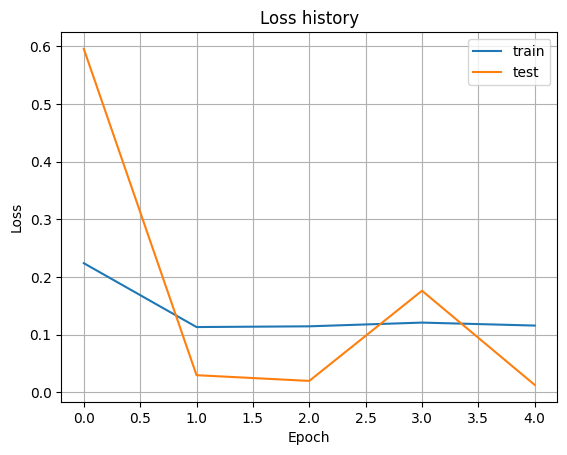

In [178]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Самыми эффективными гиперпараметрами для улучшения качества модели оказались скорость обучения (ее уменьшение) и размерность слоев(увеличение).
